### 0 - Packages & functions

In [27]:
# warnings
import warnings
warnings.filterwarnings('ignore')

# general
import pymongo
import pandas as pd
import yaml, math
import numpy as np

# stats
from scipy.stats import f_oneway
import scipy.stats as stats

# scikit
import scikit_posthocs as sp

# plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import squarify
from pywaffle import Waffle
from highlight_text import fig_text
from pypalettes import load_cmap
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"  # Para Jupyter Notebook
pio.renderers.default = "iframe"  # Para forzar que se muestre en un iframe
pio.renderers.default = "svg"  # Si necesitas una imagen estática como respaldo
pio.renderers.default = "png"  # Otra opción de imagen estática

# annotations
from highlight_text import fig_text, ax_text
from matplotlib.patches import FancyArrowPatch

`Functions`

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

def get_conn_mongo(creds_file, collection):
    creds = read_yaml_file(creds_file)['mongo']
    url=creds['url']
    db=creds['db']
    collection=collection

    return url, db, collection

def calculate_sample_size(Z=1.96, p=0.5, E=0.05):
    
    n_infinite = (Z**2 * p * (1 - p)) / (E**2)

    return math.ceil(n_infinite)

### 1 - Get the info

In [3]:
path="data/market-share.xlsx"

transactions=pd.read_excel(path, sheet_name="data")
transactions.columns=['date', 'bank', 'transactions', 'mkt-share']
transactions.head(3)

,date,bank,transactions,mkt-share
0,2023-09-01,Citibanamex,15024802,18.28
1,2023-09-01,BBVA,25882004,31.49
2,2023-09-01,Santander,8407594,10.23


### 2 - Market analysis

`Context`

The *Comisión Nacional Bancaria y de Valores (CNBV)* reports that, as of the first quarter of 2024, 87 million accounts in Mexico are conducting transactions via mobile devices—a substantial increase from the 82 million mobile banking accounts recorded in the third quarter of 2023. This trend highlights a growing reliance on mobile technology for convenient, accessible transactions.

Since the first quarter of 2017, the number of mobile banking accounts has surged sevenfold, rising from 11.8 million accounts and maintaining an impressive annual growth rate of 14.2%.

However, mobile banking adoption varies widely across Mexico, with northern states and the Yucatán Peninsula leading in digital inclusion. Mexico City, in particular, shows extraordinary penetration, boasting 18.4 million mobile accounts in 2023—over double its adult population of 7.3 million. This figure translates to 253 mobile banking accounts per 100 adults, underscoring the capital’s embrace of digital banking.

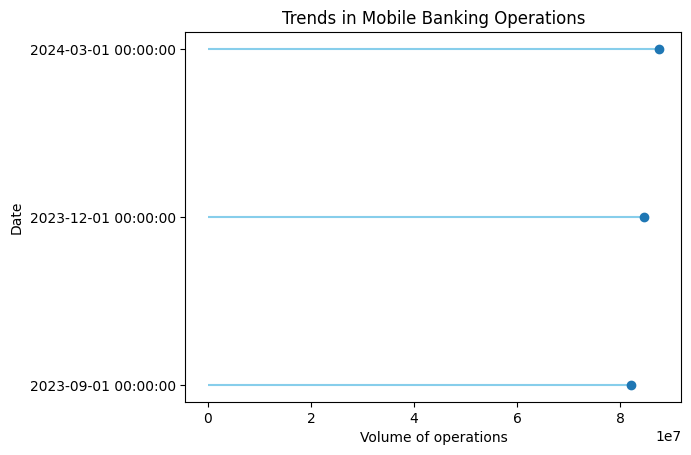

,date,transactions
0,2023-09-01,82195134
1,2023-12-01,84592583
2,2024-03-01,87541382


In [4]:
# =============================================================================
# =============================================================================
cols=['date', 'transactions']
trans_summary=transactions[cols].groupby(by="date", as_index=False).agg("sum")

# =============================================================================
# =============================================================================
# Create the plot - The horizontal plot is made using the hline function
my_range=range(1,len(trans_summary.index)+1)
plt.hlines(y=my_range, xmin=0, xmax=trans_summary['transactions'], color='skyblue', )
plt.plot(trans_summary['transactions'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, trans_summary['date'])
plt.title("Trends in Mobile Banking Operations", loc='center')
plt.xlabel('Volume of operations')
plt.ylabel('Date')

# Show the plot
plt.show()

trans_summary

In [5]:
cols=['bank', 'mkt-share']
mark_share=transactions[cols].groupby(by='bank', as_index=False)\
                                   .agg('mean')\
                                   .sort_values(by='mkt-share', ascending=False)\
                                   .reset_index(drop=True)

# ================================================================================
# ================================================================================
# Market share classification

mark_share['classification'] = np.where(mark_share['mkt-share'] > 5.0, mark_share['bank'], 'Otros')

# ================================================================================
# ================================================================================

cols=['classification', 'mkt-share']
mark_share = mark_share[cols].\
                groupby(by='classification', as_index=False).\
                agg('sum').\
                sort_values(by='mkt-share', ascending=False)

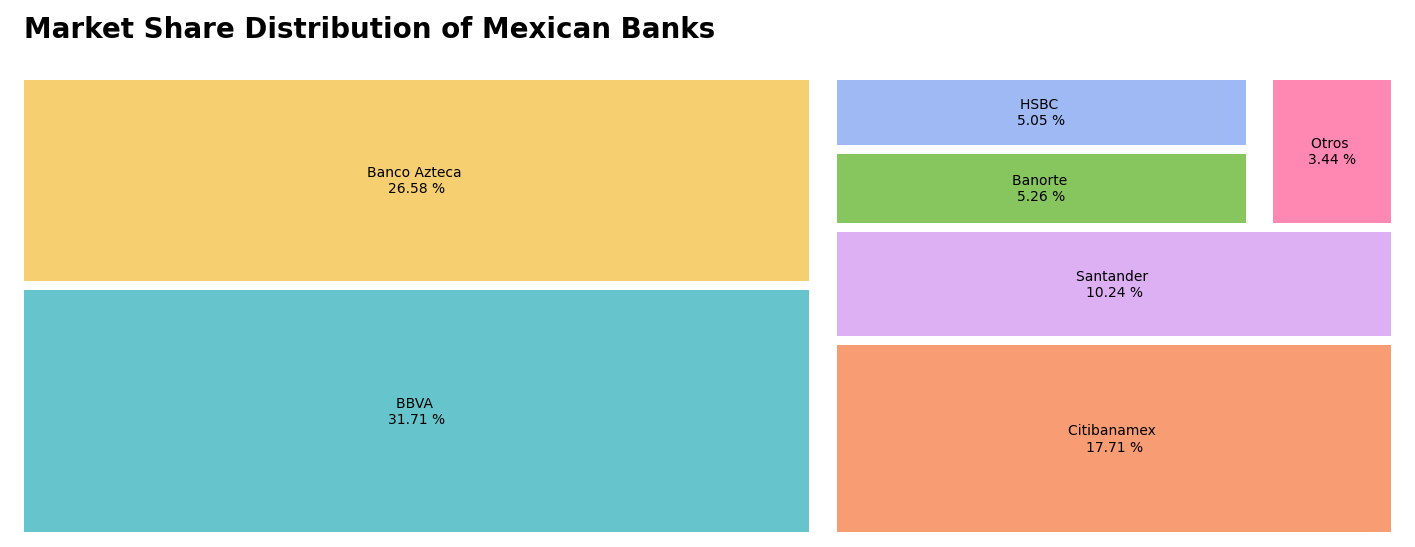

In [6]:
# create a color palette
cmap = load_cmap('Pastel')
category_codes, unique_categories = pd.factorize(mark_share['classification'])
colors = [cmap(code) for code in category_codes]

# customize the labels
labels = [f"{name} \n{value:.2f} %" for name, value in zip(mark_share['classification'], mark_share['mkt-share'])]

# create a treemap
fig, ax = plt.subplots(figsize=(18,6))
ax.set_axis_off()
squarify.plot(
   sizes=mark_share["mkt-share"],
   label=labels,
   color=colors,
   text_kwargs={'color':'black'},
   pad=True,
   ax=ax
)

# add a title and legend
text = """<Market Share Distribution of Mexican Banks>
"""
fig_text(
   x=0.133, y=0.98,
   s=text,
   color="black",
   highlight_textprops=[
      {"fontsize": 20, 'fontweight': 'bold'},
                       ],
   fontsize=14,
   ha='left'
)

plt.show()

Six major groups hold **96% of mobile-linked bank accounts.** Among them, *Grupo Santander* holds a **10.24%** share, while *BBVA* and *Banco Azteca* stand out as market leaders, showcasing rapid growth in their market share.

### Banking Industry Benchmark Analysis

- **Deposit Growth Trends**
  - *Banco Azteca* led the growth in the number of accounts between Q4 2023 and Q1 2024, with a 5.1% increase. In contrast, *Grupo Santander* saw a decline of -0.81%, falling below the market average of 0.94%. This suggests a potential customer shift towards other institutions.
<br><br>
- **Credit Market Insights**
  - *Santander* holds a notable position in the credit market with an 8.43% share. However, it lags significantly behind *BBVA*, which commands 20.11%, and *Banco Azteca*, the market leader with 24.39%.
<br><br>
- **Delinquency Rates**
  - In 2024, *Grupo Santander* reported a delinquency rate of 2.26%, higher than *BBVA's* 1.67%, but notably lower than *Banco Azteca's* 3.49%. This indicates that while *Banco Azteca* has expanded its customer base, it faces a higher credit risk among its clients.
<br><br>
- **Conclusion**
  - *Banco Azteca's* aggressive growth in account numbers and its dominant position in the credit market highlight its expanding influence in the financial sector. However, this rapid expansion comes with increased credit risk, as reflected in its higher delinquency rates. Meanwhile, *Grupo Santander*, despite a respectable share in the credit market, faces challenges with declining deposits and relatively higher delinquency compared to *BBVA*. These trends suggest that while *Banco Azteca* is capitalizing on growth opportunities, maintaining credit quality will be crucial for sustainable success. Conversely, *Grupo Santander* may need to focus on improving customer retention and managing credit risk to remain competitive.

### 3 - Analyzing Customer Experience in Banking Apps

**MongoDB data**

In [7]:
# ==========================================================================
# ==========================================================================
url_mg, db_mg, collection = get_conn_mongo("key.yaml", 'bank_reviews')

# ==========================================================================
# ==========================================================================
client = pymongo.MongoClient(url_mg)
db = client[db_mg]
collection = db[collection]

# ==========================================================================
# ==========================================================================
data=collection.find({})
documents=list(data)

# ==========================================================================
# ==========================================================================
reviews=pd.DataFrame(documents)
reviews.head()

,_id,at,score,content,bank
0,670ac0db151b1cffe5ea06a4,2024-09-07 19:04:07,3,"Buena pero tiene muchos detalles, uno de los m...",Santander
1,670ac0db151b1cffe5ea06a5,2024-09-09 18:06:53,1,La interfaz es lenta y la cuestión del superto...,Santander
2,670ac0db151b1cffe5ea06a6,2024-08-27 14:51:49,5,En dos ocasiones ha pasado que intento abrir l...,Santander
3,670ac0db151b1cffe5ea06a7,2024-09-25 11:44:10,3,Desde hace varias semanas la tarjeta de débito...,Santander
4,670ac0db151b1cffe5ea06a8,2024-08-31 14:04:55,1,"Mejoren la app, no se puede hacer nada sin ten...",Santander


The data for this analysis was gathered through a year-long scraping process from the Google Play Store.

In [8]:
print(reviews['at'].max())
print(reviews['at'].min())

2024-09-30 23:58:10
2023-09-01 00:24:33


In [9]:
# ==========================================================
# ==========================================================
# adjust the datetime format
reviews['at'] = pd.to_datetime(pd.to_datetime(reviews['at']).dt.date)

# ==========================================================
# ==========================================================
# get the month and the year
history_score = reviews.drop(columns=['_id', 'content'], inplace=False)
history_score['month'] = history_score['at'].dt.month
history_score['year'] = history_score['at'].dt.year

# ==========================================================
# ==========================================================
# group by
history_score = history_score.\
                        drop(columns=['at'], inplace=False).\
                        groupby(by=['year', 'month', 'bank'], as_index=False).\
                        agg('mean')

# Combine year and month into a single datetime column
history_score['date'] = pd.to_datetime(history_score[['year', 'month']].assign(day=1))
banks=history_score['bank'].unique()

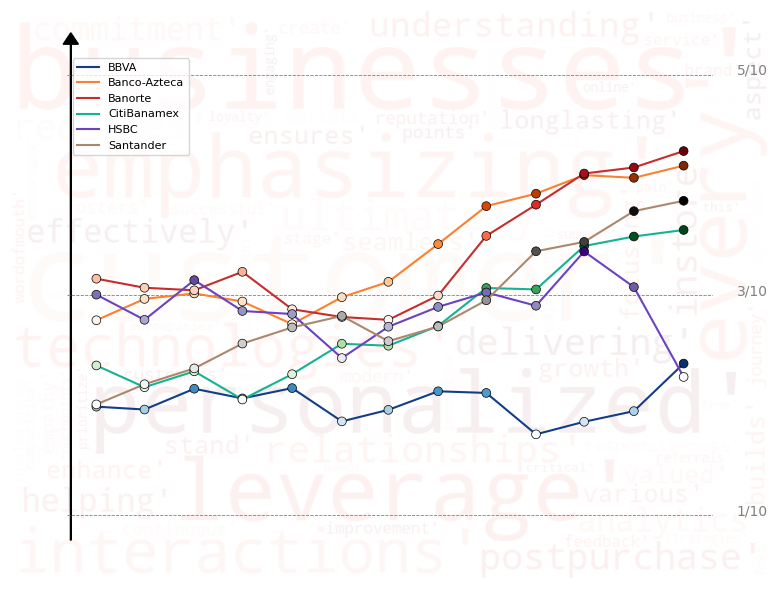

In [10]:
# create a large string with all the titles
cx_string = ['Customer experience CX is a critical aspect of modern business focusing on delivering value and satisfaction at every stage of the customer journey Successful CX strategies prioritize understanding customer needs preferences and pain points to create a seamless personalized experience This approach encompasses various touchpoints from online interactions to instore service and postpurchase support Engaging with customers effectively requires empathy responsiveness and a commitment to continuous improvement Businesses can leverage customer feedback data analytics and innovative technologies to enhance CX Ultimately a strong customer experience fosters loyalty encourages wordofmouth referrals and strengthens brand reputation helping businesses stand out in competitive markets Emphasizing CX is essential for sustainable growth as it builds longlasting relationships and ensures customers feel valued']
reviews_combined = ' '.join(cx_string)
reviews_combined = list(set(reviews_combined.split(' ')))
reviews_combined = [word.lower() for word in reviews_combined if len(word) > 3]
reviews_combined = str(reviews_combined)

# colors
colors=['#133E87', # blue
        '#FA812F', # orange
        '#C62E2E', # red
        '#15B392', # green
        '#6A42C2', # purple
        '#AB886D'] # brown

cmaps=['Blues', # blue
       'Oranges', # orange
       'Reds', # red
       'Greens', # green
       'Purples', # purple
       'Greys'] # brown

# initiate a figure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# create the wordcloud for the background
wordcloud = WordCloud(
    width=800, height=600,
    background_color='white',
    colormap='Reds',
    contour_width=1,
    contour_color='black',
    random_state=2  # fix randomness
).generate(reviews_combined)
ax.imshow(wordcloud, interpolation='bilinear', alpha=0.07)
ax.set_axis_off()

# create inside axe
sub_ax = inset_axes(
    parent_axes=ax,
    width="85%",
    height="85%",
    loc='center',
    borderpad=1
)

counter=0

for b in banks:
    sns.lineplot(
        data=history_score[history_score['bank'] == b],
        x='date', y='score',
        color=colors[counter],#'darkred',
        ax=sub_ax,
        zorder=5,
        label=b)

    # add scatter plot on top
    cmap = matplotlib.colormaps[cmaps[counter]]
    sub_ax.scatter(
        x=history_score[history_score['bank'] == b]['date'],
        y=history_score[history_score['bank'] == b]['score'],
        cmap=cmap,
        c=history_score[history_score['bank'] == b]['score'],
        s=40,
        edgecolor='black',
        linewidth=0.5,
        zorder=10)
    
    # increment the counter
    counter+=1

# remove background from line chart
sub_ax.set_axis_off()

# display references
max_rate = 5
min_rate = 1
mid_rate = 3
sub_ax.axhline(y=max_rate, color='grey', linestyle='--', lw=0.6)
sub_ax.axhline(y=min_rate, color='grey', linestyle='--', lw=0.6)
sub_ax.axhline(y=mid_rate, color='grey', linestyle='--', lw=0.6)

sub_ax.text(20000, max_rate, f"{max_rate:.0f}/5",
            fontsize=10, color='grey')
sub_ax.text(20000, min_rate, f"{min_rate:.0f}/5",
            fontsize=10, color='grey')
sub_ax.text(20000, mid_rate, f"{mid_rate:.0f}/5",
            fontsize=10, color='grey')

# vertical line arrow for y axis of the subax
ax.arrow(
    0.08, 0.07, 0, 0.87,
    head_width=0.02, 
    head_length=0.02,
    fc='black', ec='black',
    transform=ax.transAxes
)

# display chart
plt.tight_layout()
plt.legend(loc="upper left", fontsize=8)
plt.show()

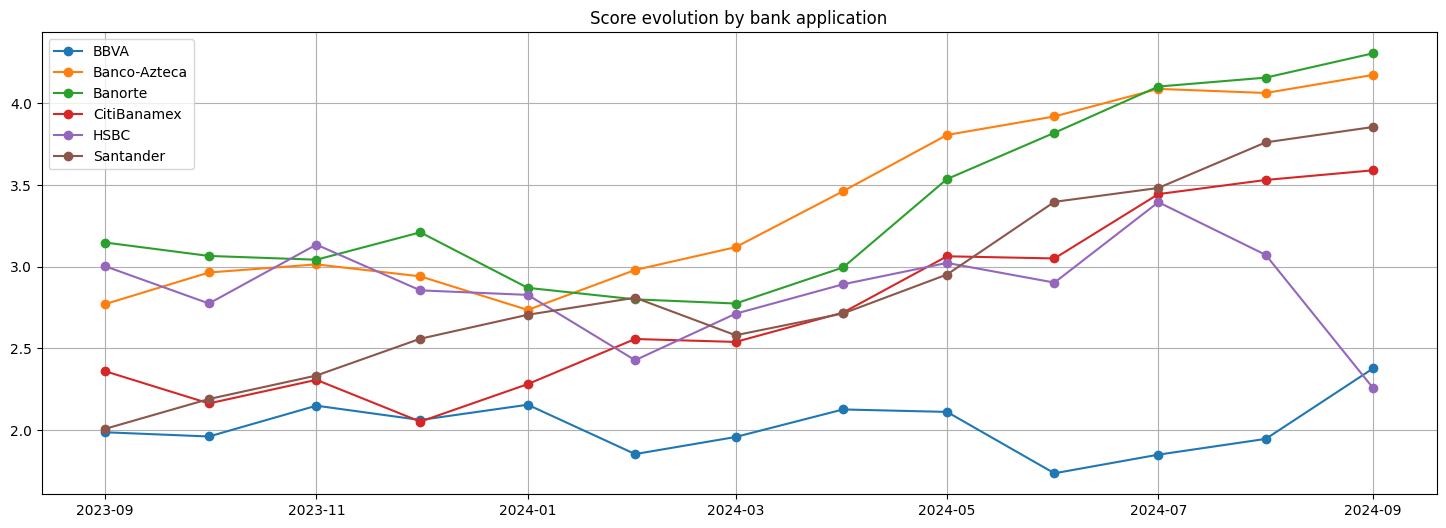

In [11]:
# ==========================================================
# ==========================================================
# plot
plt.figure(figsize=(18,6))

for b in banks:
    plt.plot('date', 
             'score', 
             data=history_score[history_score['bank'] == b], 
             linestyle='-', 
             marker='o', 
             label=b)
    
plt.title("Score evolution by bank application")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

The analysis of user ratings from Google Play reveals a clear hierarchy among Mexico’s mobile banking apps. *Banorte* and *Banco Azteca* stand out as clear winners, showcasing robust customer satisfaction and well-executed digital strategies. In contrast, *BBVA* lags behind, indicating room for significant improvement in user experience. *Santander*, while not leading, maintains a solid third place. 

Our focus on highlighted reviews—those deemed most relevant or popular—provides a richer understanding of customer sentiment. These reviews uncover user preferences, pain points, and desired features, offering valuable market intelligence. By addressing this feedback, banks can refine their apps, boost user retention, and sharpen their competitive edge in an increasingly digital-first landscape.

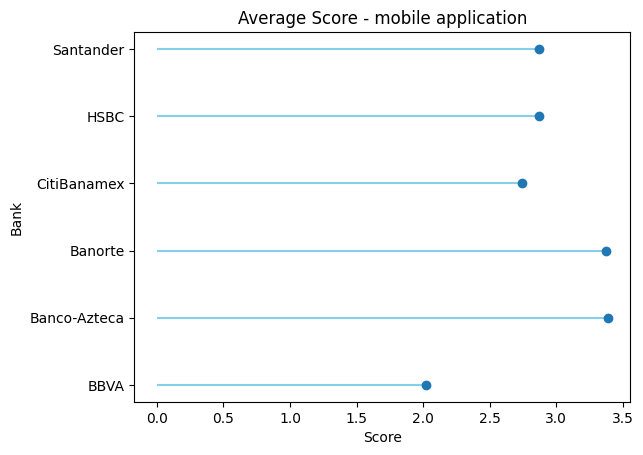

In [12]:
# =======================================================================================
# =======================================================================================
# get the average score
cols=['score', 'bank']
avg_score=history_score[cols].groupby(by='bank', as_index=False).agg('mean')

# =======================================================================================
# =======================================================================================
# define the range
my_range=range(1,len(avg_score.index)+1)

# =======================================================================================
# =======================================================================================
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=0, xmax=avg_score['score'], color='skyblue')
plt.plot(avg_score['score'], my_range, "o")

# =======================================================================================
# =======================================================================================
# Add titles and axis names
plt.yticks(my_range, avg_score['bank'])
plt.title("Average Score - mobile application", loc='center')
plt.xlabel('Score')
plt.ylabel('Bank')

# Show the plot
plt.show()

When looking at the overall average ratings, *Banco Azteca* consistently emerges as the top performer, boasting the highest user satisfaction. On the other end of the spectrum, *BBVA* faces challenges, showing the lowest average rating. This stark contrast underscores *Banco Azteca’s* effective approach to user experience while highlighting critical areas for *BBVA* to address in order to enhance its app’s performance and meet customer expectations.

#### Clustering

Based on key features such as user ratings of mobile applications, deposit growth trends, credit market insights, delinquency rates, branch network, and market share, we have identified distinct customer segments.

In this analysis, *BBVA* stands out as the clear market **leader**. Meanwhile, *Santander* and *Banamex* are positioned as strong **challengers**, competing closely in the same cluster. In a different segment, *Banco Azteca* emerges in the **"Opportunities"** cluster, showing significant potential for improvement, particularly in delinquency rates. Finally, banks like *Banregio* and *HSBC*, with smaller market shares, fall into the **"Niche & Emerging"** segment, highlighting their focus on specific market areas or emerging opportunities.

In [13]:
from IPython.display import display, HTML

image_path = "img\clusters-banks.png"
html_code = f"""
<center>
    <img src="{image_path}" width="800">
</center>
"""
display(HTML(html_code))

**Sample Size**

When analyzing bank app reviews, it’s essential to consider the sample size to ensure that the insights gathered are both reliable and representative of the entire user base. The sample size directly influences the accuracy of the analysis, helping avoid biased or skewed results. A sufficient sample size provides a balanced view of user feedback, captures genuine patterns, and reduces the risk of basing decisions on random fluctuations. 

Below, we outline why this is important and provide a detailed guide on how to calculate the optimal sample size for a robust analysis.

1. *Why is Sample Size Important?*
    - *Accuracy and Representativeness:* A small sample size may not accurately reflect the overall sentiment or user experience. It could be biased by a few extreme reviews, either very positive or very negative. A larger sample size, on the other hand, tends to provide a more balanced view.<br>
*Statistical Significance:* Without a sufficient sample size, any conclusions drawn may be due to random chance rather than genuine patterns or trends. For instance, if only 20 users out of millions rate an app poorly, it doesn't necessarily indicate a significant issue with the app.<br>
*Reduced Margin of Error:* A larger sample size reduces the margin of error, increasing the confidence in your findings. For example, if 5% of users rate a bank app poorly with a small sample size, the actual percentage could be much higher or lower when considering the entire user base.<br>
*Improved Decision-Making:* Banks use user feedback to make critical decisions about product improvements, bug fixes, and feature updates. Analyzing a representative sample ensures that these decisions are based on the true needs and preferences of the majority, rather than being skewed by a few outliers.
<br><br>
2. How to Calculate Sample Size
    - To determine an appropriate sample size for analyzing reviews, you can use the following formula for calculating the sample size based on a desired confidence level and margin of error:

$$ n = \frac{Z^2 * p * (1-p)}{E^2} $$

Where:

- n = Sample size
- Z = Z-score (based on the desired confidence level, e.g., 1.96 for 95% confidence)
- p = Estimated proportion of the population with the characteristic of interest (e.g., the proportion of negative reviews; if unknown, use 0.5 for maximum variability)
- E = Margin of error (the desired level of precision, e.g., 0.05 for ±5%)

In [14]:
Z = 1.96
p = 0.5
E = 0.05

sample_size = calculate_sample_size(Z, p, E)
print(f"Sample size: {sample_size}")

Sample size: 385


From our analysis, several key considerations emerge:

- *Large User Base:* For widely used bank apps with millions of users, a sample size of approximately 385 reviews is typically sufficient to achieve a 95% confidence level, as we calculated earlier. This ensures that the insights are statistically significant and reflective of the broader user experience.

- *High Variability in Reviews:* Feedback on bank apps can vary greatly due to factors like device compatibility, regional features, and individual user expectations. To account for this diversity, using an estimated proportion (p) of 0.5 is recommended, as it maximizes the variability and improves the reliability of the analysis.

**Reviews by bank**

In [15]:
cols=['_id', 'bank']
total_reviews = reviews[cols].\
                        groupby(by='bank', as_index=False).\
                        agg('count').\
                        sort_values(by='_id', ascending=False)

*Waffle graph*

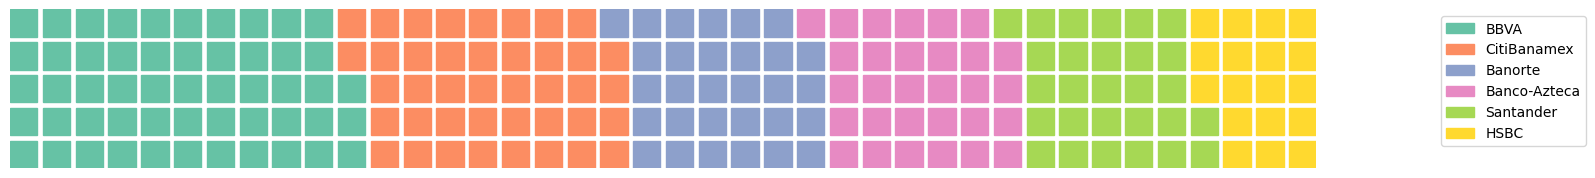

In [16]:
plt.figure(
  figsize=(16,6),
  FigureClass=Waffle,
  rows=5,
  columns=40,
  values=total_reviews.set_index('bank').to_dict(orient='dict')['_id'],
  legend={'loc': 'upper left', 'bbox_to_anchor': (1.09, 1)},
)

plt.show()

In [17]:
total_reviews

,bank,_id
0,BBVA,13854
3,CitiBanamex,10736
2,Banorte,7892
1,Banco-Azteca,7774
5,Santander,7233
4,HSBC,5054


**Findings**

At this point, we have established that our chosen sample size is appropriate for a reliable analysis. From the data, *Banorte* and *Banco Azteca* emerge as the top-performing bank apps, showcasing strong user ratings and positive feedback. However, despite *BBVA’s* position as the market leader in Mexico, there are significant areas for improvement in its app performance. This highlights an important opportunity for *BBVA* to enhance its user experience and maintain its competitive edge in the market.

#### ANOVA

ANOVA, or Analysis of Variance, is a statistical method used to compare the average scores of different groups to see if there are significant differences. In the context of bank app scores, ANOVA helps us determine if the differences in user ratings between several bank apps (like BBVA, Banorte, and Banco Azteca) are statistically significant or just due to random variation.

*Why is this important?*
- Because banks use these app scores to understand user satisfaction. By applying ANOVA, we can confidently say which bank apps perform better and identify areas needing improvement. This method provides banks with clear, data-backed insights rather than relying on guesswork, helping them make informed decisions to enhance the customer experience.

**Important**
- Before proceeding, we need to check if the ratings follow a normal distribution. If the data does not follow a normal distribution, it is not appropriate to apply ANOVA directly, as this test assumes normality and homogeneity of variances. Instead, you can opt for a non-parametric test. The most commonly used alternative in this scenario is the *Kruskal-Wallis* test, which does not require the data to follow a normal distribution.

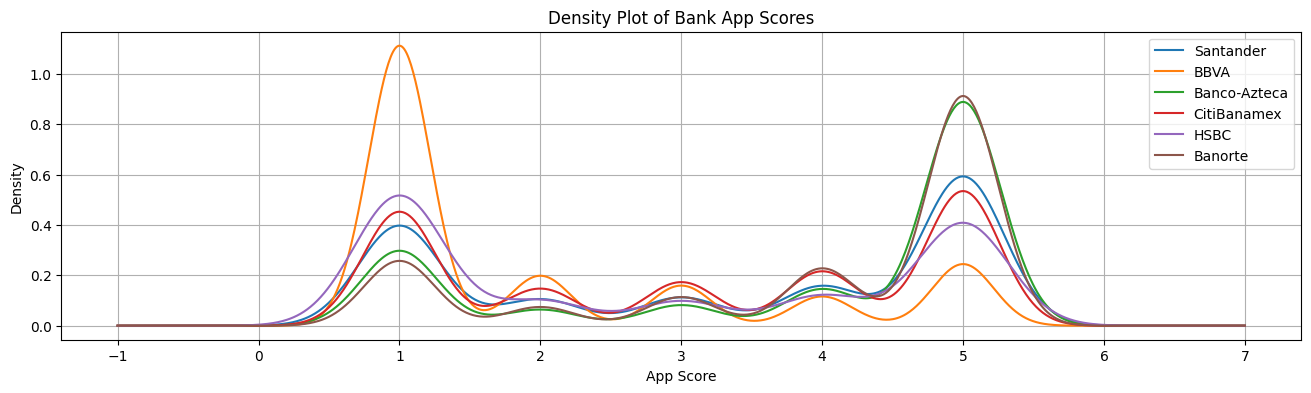

In [18]:
# ============================================================
cols=['bank', 'score']
scores=reviews[cols]
banks=scores['bank'].unique()

# ============================================================
# Plot KDE
for b in banks:
    data=scores[scores["bank"] == b]

    # ============================================================
    data['score'].plot.kde(figsize=(16, 4), label=b)

# Adding labels and title
plt.xlabel('App Score')
plt.ylabel('Density')
plt.title('Density Plot of Bank App Scores')
plt.legend()
plt.grid()
plt.show()

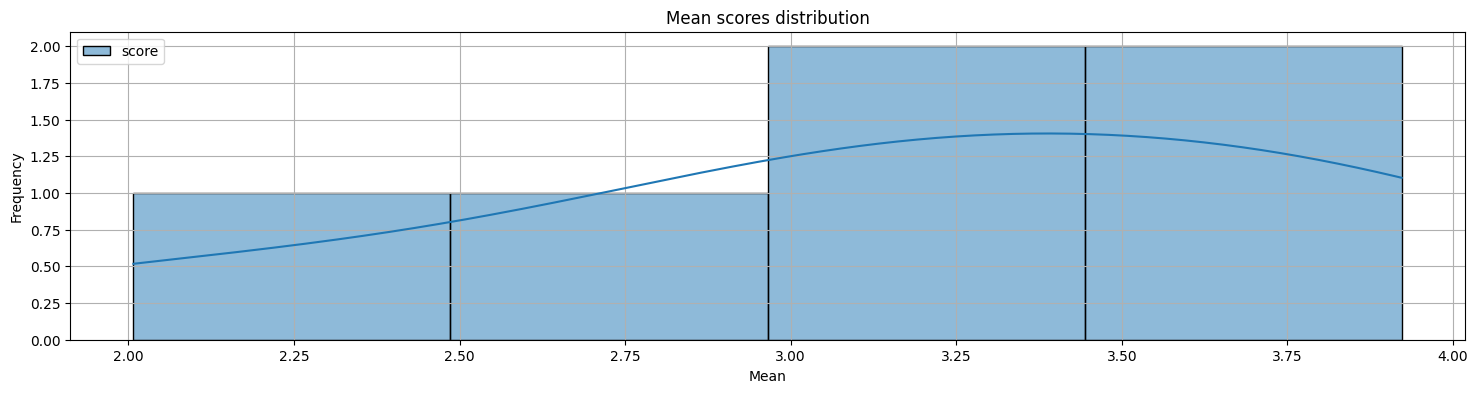

In [32]:
# ================================================================
mean_scores=scores.groupby(by='bank', as_index=False).agg('mean')

# ================================================================
# ================================================================
plt.figure(figsize=(18, 4))
sns.histplot(mean_scores, kde=True,)
plt.title('Mean scores distribution')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [38]:
# =================================================================================================
results = []

# =================================================================================================
for b in banks:
    
    # split data
    data=scores[scores["bank"] == b]['score']
    
    # Prueba de Kolmogorov-Smirnov
    ks_statistic, p_value = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    
    # Guardamos los resultados
    results.append({
        'Banco': b,
        'KS Statistic': ks_statistic,
        'P-Value': p_value,
        'Normalidad': 'No Normal' if p_value < 0.05 else 'Normal'
    })
    
pd.DataFrame(results)

,Banco,KS Statistic,P-Value,Normalidad
0,Santander,0.268309,0.000000e+00,No Normal
1,BBVA,0.361342,0.000000e+00,No Normal
2,Banco-Azteca,0.361788,0.000000e+00,No Normal
3,CitiBanamex,0.215841,0.000000e+00,No Normal
4,HSBC,0.267320,2.268255e-319,No Normal
5,Banorte,0.337109,0.000000e+00,No Normal


As we observed in the previous analysis, our ratings do not follow a normal distribution.

**Alternative: Kruskal-Wallis Test**
- The *Kruskal-Wallis* test is a non-parametric test that compares the medians of two or more groups to determine if there are significant differences between them. It is analogous to ANOVA but designed for data that do not meet the assumptions of normality.

In [48]:
scores_by_bank = [scores[scores['bank'] == b]['score'] for b in banks]

h_statistic, p_value = stats.kruskal(*scores_by_bank)

print(f"Kruskal-Wallis H statistic: {h_statistic}")
print(f"P-value: {p_value}")

# Interpretación
if p_value < 0.05:
    print("There are significant differences between the ratings of the different banks.")
else:
    print("No significant differences were found between the ratings of the different banks.")

Kruskal-Wallis H statistic: 8577.317657688347
P-value: 0.0
There are significant differences between the ratings of the different banks.


**Dunn's Test**<br>
When we want to compare multiple groups (e.g., ratings of different banks) to see if there are significant differences, we often use tests like ANOVA or Kruskal-Wallis. However, these tests only tell us that a difference exists but not specifically between which groups. This is where Dunn's Test comes in.

*What is Dunn's Test?*<br>
- Dunn's Test is a post hoc test, meaning it is used after identifying a significant difference with a test like Kruskal-Wallis. Its purpose is to perform pairwise comparisons between groups to pinpoint exactly which ones differ.


*Example:*<br>
- Let’s say we have 3 banks: Bank A, Bank B, and Bank C.

  The *Kruskal-Wallis* test shows a significant difference in ratings among at least one of the banks.

  Now, we use Dunn's Test to determine which pairs of banks differ:

  Compare Bank A vs. Bank B.<br>
  Compare Bank A vs. Bank C.<br>
  Compare Bank B vs. Bank C.<br>

  If the result shows that the comparison between Bank A and Bank B has a p-value below 0.05, it means there is a significant difference in ratings between these two banks.

**Wy is it useful?**
- Identifies specific differences: Helps determine which banks have better or worse perceptions.
  Reduces error risk: Adjusts p-values (using Bonferroni correction) to lower the risk of false positives when making multiple comparisons.

*In Summary:*
- Use *Dunn's Test* for pairwise comparisons to identify where the differences lie.
- It’s helpful after finding significant differences with a test like *Kruskal-Wallis.*
- It guides you to take targeted actions for improvement in the groups showing negative differences.

In [49]:
dunn_test = sp.posthoc_dunn(scores, val_col='score', group_col='bank', p_adjust='bonferroni')
print("Results of Dunn's Test:")
dunn_test

Results of Dunn's Test:


,BBVA,Banco-Azteca,Banorte,CitiBanamex,HSBC,Santander
BBVA,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.913677e-177,0.000000e+00
Banco-Azteca,0.000000e+00,1.000000e+00,1.000000e+00,7.435173e-168,1.105531e-225,1.152513e-77
Banorte,0.000000e+00,1.000000e+00,1.000000e+00,1.274424e-190,3.761131e-247,1.566487e-91
CitiBanamex,0.000000e+00,7.435173e-168,1.274424e-190,1.000000e+00,8.639941e-22,5.846607e-11
HSBC,2.913677e-177,1.105531e-225,3.761131e-247,8.639941e-22,1.000000e+00,2.695628e-49
Santander,0.000000e+00,1.152513e-77,1.566487e-91,5.846607e-11,2.695628e-49,1.000000e+00


**`Findings`**<br><br>

After conducting the tests, we can determine that there are significant differences in the ratings among the various competitors in the market. Analyzing these ratings using statistical tests like the *Kruskal-Wallis* and *Dunn's Test* helps identify weaknesses and significant differences between banks. 

**This information is crucial for:**
- Identifying areas for improvement.
- Optimizing the user experience.
- Making informed decisions for enhancements.

These actions lead to higher customer satisfaction, which in turn can result in better retention, increased loyalty, and potentially higher conversions and app usage.